# Tutorial 1: Sistemas Dinámicos Lineales

---
# Objetivos del Tutorial

En este tutorial, aprenderemos sobre el comportamiento de sistemas dinámicos —sistemas que evolucionan en el tiempo— donde las reglas por las cuales evolucionan en el tiempo se describen precisamente por una ecuación diferencial.

Las ecuaciones diferenciales son ecuaciones que expresan la **tasa de cambio** de la variable de estado $x$. Normalmente se describe esta tasa de cambio usando la derivada de $x$ con respecto al tiempo ($dx/dt$) en el lado izquierdo de la ecuación diferencial:

\begin{equation}
\frac{dx}{dt} = f(x)
\end{equation}

Una notación común es escribir $\dot{x}$ para $\frac{dx}{dt}$. El punto significa "la derivada con respecto al tiempo".

Hoy, el enfoque será en la **dinámica lineal**, donde $f(x)$ es una función lineal de $x$. En el Tutorial 1, vamos a:

* Explorar y entender el comportamiento de tales sistemas donde $x$ es una variable única
* Considerar casos donde $\mathbf{x}$ es un vector de estado que representa dos variables.

---
# Configuración

In [1]:
# @title Instalar e importar el gadget de retroalimentación

!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # Sin mensaje de texto
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_cn",
            "user_key": "y1x3mpx5",
        },
    ).render()


feedback_prefix = "W2D2_T1"

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.2 MB/s eta 0:00:00


In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp  # solucionador de integración numérica

In [3]:
# @title Configuración de figuras
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # visualización interactiva
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [4]:
# @title Funciones de Trazado
def plot_trajectory(system, params, initial_condition, dt=0.1, T=6,
                    figtitle=None):

  """
  Muestra la solución de un sistema lineal con dos variables en 3 gráficos.
  El primer gráfico muestra x1 a lo largo del tiempo. El segundo gráfico muestra x2 a lo largo del tiempo.
  El tercer gráfico muestra x1 y x2 en un retrato de fase.

  Args:
    system (function): una función f(x) que calcula una derivada a partir de
                        entradas (t, [x1, x2], *params)
    params (lista o tupla): lista de parámetros para la función "system"
    initial_condition (lista o array): condición inicial x0
    dt (float): paso de tiempo de la simulación
    T (float): tiempo final de la simulación
    figtitle (string): título para la figura

  Devuelve:
    nada, pero muestra una figura
  """

  # puntos de tiempo para los cuales queremos evaluar soluciones
  t = np.arange(0, T, dt)

  # Integra
  # usa el solucionador de ecuaciones diferenciales ordinarias integrado
  solution = solve_ivp(system,
                    t_span=(0, T),
                    y0=initial_condition, t_eval=t,
                    args=(params),
                    dense_output=True)
  x = solution.y

  # crea un mapa de colores para visualizar el tiempo
  timecolors = np.array([(1 , 0 , 0, i)  for i in t / t[-1]])

  # crea una figura grande
  fig, (ah1, ah2, ah3) = plt.subplots(1, 3)
  fig.set_size_inches(10, 3)

  # traza x1 como función del tiempo
  ah1.scatter(t, x[0,], color=timecolors)
  ah1.set_xlabel('time')
  ah1.set_ylabel('x1', labelpad=-5)

  # traza x2 como función del tiempo
  ah2.scatter(t, x[1], color=timecolors)
  ah2.set_xlabel('time')
  ah2.set_ylabel('x2', labelpad=-5)

  # traza x1 y x2 en un retrato de fase
  ah3.scatter(x[0,], x[1,], color=timecolors)
  ah3.set_xlabel('x1')
  ah3.set_ylabel('x2', labelpad=-5)
  #incluye la condición inicial es una cruz azul
  ah3.plot(x[0,0], x[1,0], 'bx')

  # ajusta el espaciado entre subtramas
  plt.subplots_adjust(wspace=0.5)

  # añade título a la figura
  if figtitle is not None:
    fig.suptitle(figtitle, size=16)
  plt.show()


def plot_streamplot(A, ax, figtitle=None, show=True):
  """
  Muestra un gráfico de flujo para una ecuación diferencial ordinaria lineal con
  vector de estado x=[x1,x2] en el eje ax.

  Args:
    A (array de numpy): matriz 2x2 que especifica el sistema dinámico
    ax (matplotlib.axes): eje para trazar
    figtitle (string): título para la figura
    show (booleano): habilita plt.show()

  Devuelve:
    nada, pero muestra una figura
  """

  # muestrea una grilla 20 x 20 uniformemente para obtener x1 y x2
  grid = np.arange(-20, 21, 1)
  x1, x2 = np.meshgrid(grid, grid)

  # calcula x1dot y x2dot en cada punto de la grilla
  x1dot = A[0,0] * x1 + A[0,1] * x2
  x2dot = A[1,0] * x1 + A[1,1] * x2

  # crea un mapa de colores
  magnitude = np.sqrt(x1dot ** 2 + x2dot ** 2)
  color = 2 * np.log1p(magnitude) #Avoid taking log of zero

  # traza
  plt.sca(ax)
  plt.streamplot(x1, x2, x1dot, x2dot, color=color,
                 linewidth=1, cmap=plt.cm.cividis,
                 density=2, arrowstyle='->', arrowsize=1.5)
  plt.xlabel(r'$x1$')
  plt.ylabel(r'$x2$')

  # título de la figura
  if figtitle is not None:
    plt.title(figtitle, size=16)

  # incluye autovectores
  if True:
    # obtener valores propios y vectores propios de A
    lam, v = np.linalg.eig(A)

    # obtener vectores propios de A
    eigenvector1 = v[:,0].real
    eigenvector2 = v[:,1].real

    # trazar vectores propios
    plt.arrow(0, 0, 20*eigenvector1[0], 20*eigenvector1[1],
              width=0.5, color='r', head_width=2,
              length_includes_head=True)
    plt.arrow(0, 0, 20*eigenvector2[0], 20*eigenvector2[1],
              width=0.5, color='b', head_width=2,
              length_includes_head=True)
  if show:
    plt.show()


def plot_specific_example_stream_plots(A_options):
  """
  Muestra un gráfico de flujo para cada A en A_options

  Args:
    A (lista): una lista de arrays de numpy (cada elemento es A)

  Devuelve:
    nada, pero muestra una figura
  """
  # obtiene gráficos de flujo para los cuatro sistemas diferentes
  plt.figure(figsize=(10, 10))

  for i, A in enumerate(A_options):

    ax = plt.subplot(2, 2, 1+i)
    # obtener valores propios y vectores propios
    lam, v = np.linalg.eig(A)

    # trazar valores propios como título
    # (dos espacios se ven mejor que uno)
    eigstr = ",  ".join([f"{x:.2f}" for x in lam])
    figtitle =f"A with eigenvalues\n"+ '[' + eigstr + ']'
    plot_streamplot(A, ax, figtitle=figtitle, show=False)

    # Eliminar etiquetas y en gráficos a la derecha
    if i % 2:
      ax.set_ylabel(None)
    if i < 2:
      ax.set_xlabel(None)

    plt.subplots_adjust(wspace=0.3, hspace=0.3)
  plt.show()

---
# Sección 1: Ecuaciones diferenciales unidimensionales

Este video sirve como una introducción a los sistemas dinámicos como la matemática de cosas que cambian en el tiempo, incluyendo ejemplos de escalas de tiempo relevantes para la neurociencia. Cubre la definición de un sistema lineal y por qué dedicamos un día entero a los sistemas dinámicos lineales, y explica las soluciones a sistemas dinámicos deterministas unidimensionales, sus comportamientos y criterios de estabilidad.

Tenga en cuenta que esta sección es un resumen de los [Tutoriales 2](https://compneuro.neuromatch.io/tutorials/W0D4_Calculus/student/W0D4_Tutorial2.html) y [3](https://compneuro.neuromatch.io/tutorials/W0D4_Calculus/student/W0D4_Tutorial3.html) de nuestro día de cálculo previo al curso.

<details>
<summary> <font color='blue'>Haz clic aquí para un resumen del video</font></summary>

Empecemos recordando una ecuación diferencial unidimensional en $x$ de la forma

$$\dot{x} = a x$$

donde $a$ es un escalar.

Las soluciones de cómo $x$ evoluciona en el tiempo cuando su dinámica está gobernada por tal ecuación diferencial toman la forma

\begin{equation}
x(t) = x_0\exp(a t)
\end{equation}

donde $x_0$ es la **condición inicial** de la ecuación, es decir, el valor de $x$ en el tiempo $0$.
</details>

Para obtener más intuición, exploremos el comportamiento de tales sistemas con una simulación simple. Podemos simular una ecuación diferencial ordinaria aproximando o modelando el tiempo como una lista discreta de pasos de tiempo $t_0, t_1, t_2, \dots$, de tal manera que $t_{i+1}=t_i+dt$. Podemos obtener el pequeño cambio $dx$ durante una corta duración $dt$ de tiempo a partir de la definición del diferencial:

\begin{eqnarray}
\dot x &=& \frac{dx}{dt} \\
dx &=& \dot x\, dt
\end{eqnarray}

Así, en cada paso de tiempo $t_i$, calculamos un valor de $x$, $x(t_i)$, como la suma del valor de $x$ en el paso de tiempo anterior, $x(t_{i-1})$, y un pequeño cambio $dx=\dot x\,dt$:

\begin{equation}
x(t_i)=x(t_{i-1})+\dot x(t_{i-1}) dt
\end{equation}

Este esquema de integración muy simple, conocido como **integración Euler hacia adelante**, funciona bien si $dt$ es pequeño y la ecuación diferencial ordinaria es simple. Puede tener problemas cuando la ecuación diferencial ordinaria es muy ruidosa o cuando la dinámica incluye cambios bruscos y grandes de $x$. Tales saltos grandes pueden ocurrir, por ejemplo, en modelos de neuronas excitables. En tales casos, se necesita elegir un esquema de integración cuidadosamente. Sin embargo, para nuestro sistema simple, el esquema de integración simple debería funcionar perfectamente.

## Ejercicio de Programación 1: Integración Euler hacia Adelante

*Referido como Ejercicio 1B en el video*

En este ejercicio, completaremos una función, ``integrate_exponential``, para calcular la solución de la ecuación diferencial $\dot{x} = a x$ utilizando la integración Euler hacia adelante. Luego, graficaremos esta solución a lo largo del tiempo.





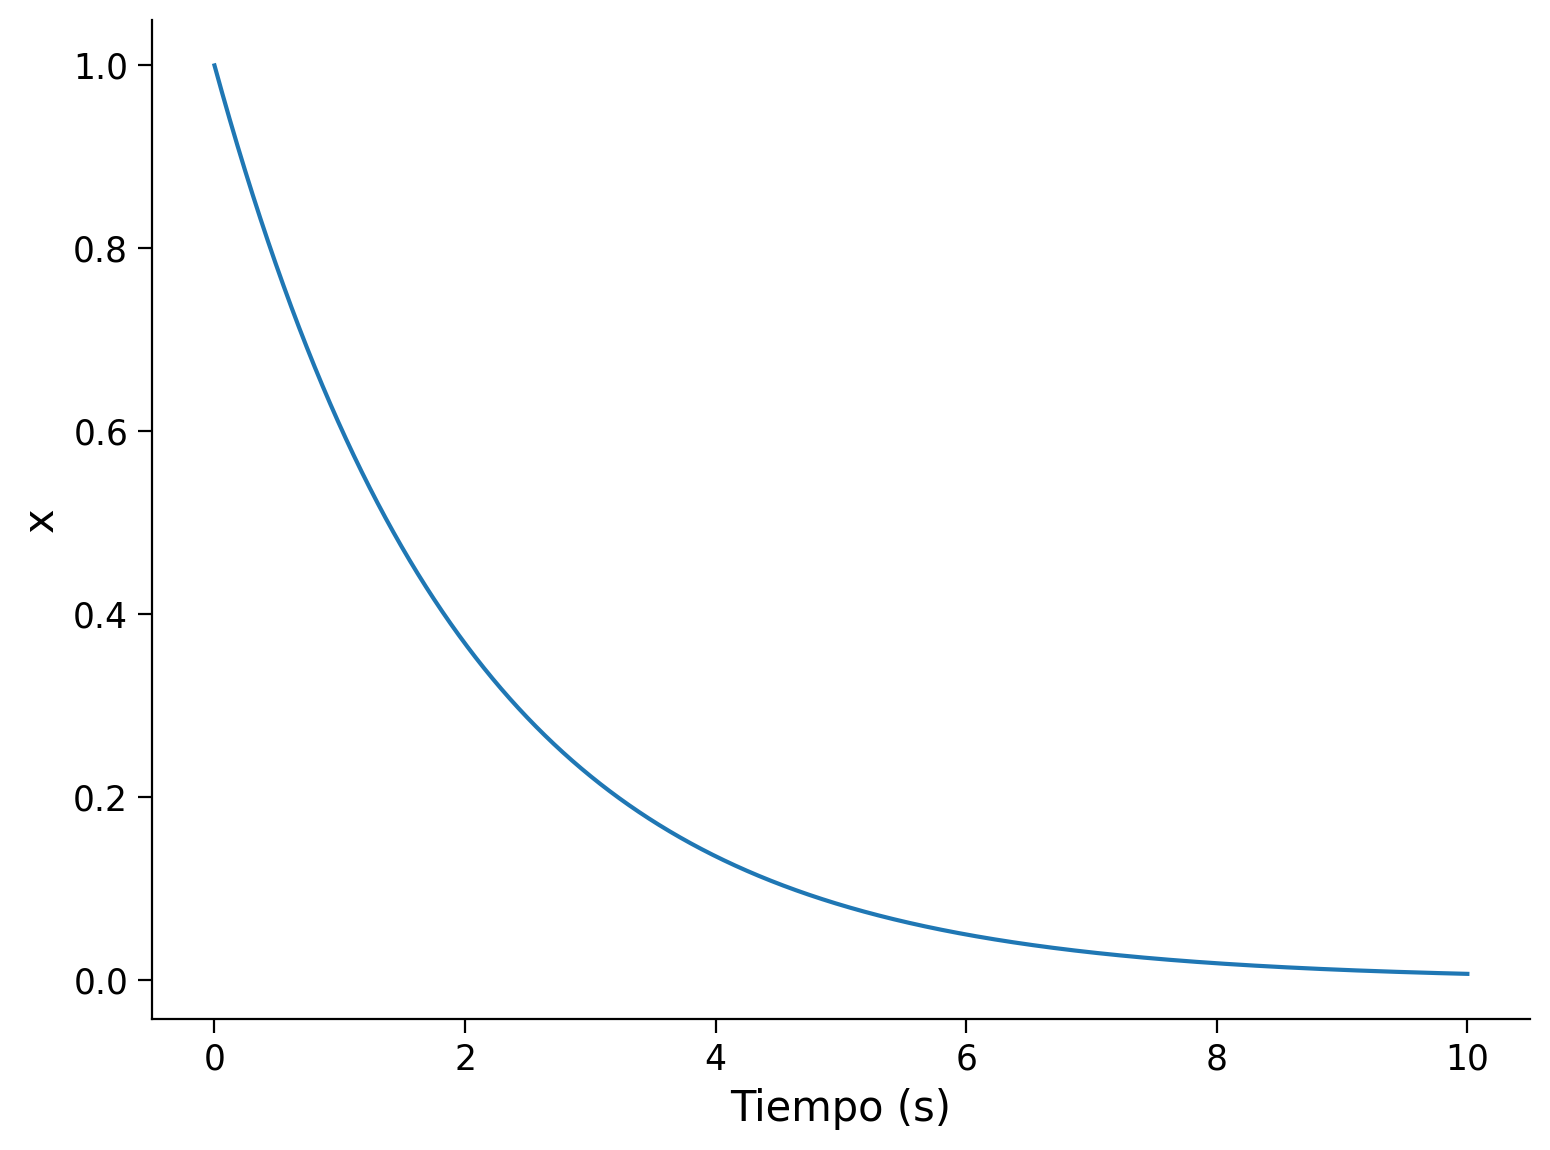

In [5]:
def integrate_exponential(a, x0, dt, T):
  """Calcular la solución de la ecuación diferencial xdot=a*x con
  condición inicial x0 durante una duración T. Usa el paso de tiempo dt para
  la solución numérica.

  Args:
    a (escalar): parámetro de xdot (xdot=a*x)
    x0 (escalar): condición inicial (x en el tiempo 0)
    dt (escalar): paso de tiempo de la simulación
    T (escalar): duración total de la simulación

  Devuelve:
    ndarray, ndarray: `x` para todos los pasos de la simulación y el tiempo `t` en cada paso
  """

  # Inicializar variables
  t = np.arange(0, T, dt)
  x = np.zeros_like(t, dtype=complex)
  x[0] = x0 # Esto es x en el tiempo t_0

  # Avanzar a través del sistema e integrar en el tiempo
  for k in range(1, len(t)):

    # para cada punto en el tiempo, calcular xdot de x[k-1]
    xdot = (a*x[k-1])

    # Actualizar x basado en x[k-1] y xdot
    x[k] = x[k-1] +  xdot * dt
    #PARA EL QUE QUIERA ALGO MÁS POWER, BUSQUEN RUNGE-KUTTA 4
  return x, t


# Elegir parámetros
a = -0.5    # parámetro en f(x)
T = 10      # Duración total del tiempo
dt = 0.001  # paso de tiempo de nuestra simulación
x0 = 1.     # condición inicial de x en el tiempo 0

# Usar el método de Euler
x, t = integrate_exponential(a, x0, dt, T)

# # Visualizar
plt.plot(t, x.real)
plt.xlabel('Tiempo (s)')
plt.ylabel('x')
plt.show()

## Demostración Interactiva 1: Integración Euler hacia Adelante

¿Qué le pasa a la solución numérica cuando aumentas $dt$?

In [12]:
# @markdown ¡Asegúrate de ejecutar esta celda para habilitar el widget!

T = 10  # Duración total del tiempo
x0 = 1.  # Condición inicial de x en el tiempo 0

@widgets.interact(
    a=widgets.FloatSlider(value=-0.5, min=-2.5, max=1.5, step=0.25,
                          description="α", formato_lectura='.2f'),
    dt=widgets.FloatSlider(value=0.001, min=0.001, max=4.0, step=0.001,
                           description="dt", formato_lectura='.3f')
    )

def plot_euler_integration(a, dt):
  # Tenemos que hacer este complicado rodeo para mostrar valores pequeños en el deslizador con precisión
  # (de https://github.com/jupyter-widgets/ipywidgets/issues/259)

  x, t = integrate_exponential(a, x0, dt, T)
  plt.plot(t, x.real)  # integrate_exponential devuelve complejo
  plt.xlabel('Tiempo (s)')
  plt.ylabel('x')
  plt.show()

interactive(children=(FloatSlider(value=-0.5, description='α', max=1.5, min=-2.5, step=0.25), FloatSlider(valu…

---
# Sección 2: Dinámicas Oscilatorias

## Demostración Interactiva 2: Dinámicas Oscilatorias

En la siguiente demostración, puedes cambiar la parte real e imaginaria de $a$ (así que a = real + imaginario i)

1. ¿Qué valores de $a$ producen dinámicas que ***oscilan*** y ***crecen***?
2. ¿Qué valor de $a$ se necesita para producir una oscilación estable de 0.5 Hertz (ciclos/unidades de tiempo)?


In [13]:
# @markdown ¡Asegúrate de ejecutar esta celda para habilitar el widget!

# parámetros
T = 5  # Duración total del tiempo
dt = 0.0001  # paso de tiempo de nuestra simulación
x0 = 1.  # condición inicial de x en el tiempo 0

@widgets.interact
def plot_euler_integration(real=(-2, 2, .2), imaginary=(-4, 7, .1)):

  a = complex(real, imaginary)
  x, t = integrate_exponential(a, x0, dt, T)
  plt.plot(t, x.real)  # integrate_exponential devuelve complejo
  plt.grid(True)
  plt.xlabel('Tiempo (s)')
  plt.ylabel('x')
  plt.show()

interactive(children=(FloatSlider(value=0.0, description='real', max=2.0, min=-2.0, step=0.2), FloatSlider(val…

---
# Sección 3: Dinámicas Lineales Deterministas en Dos Dimensiones

Este video sirve como una introducción a los sistemas dinámicos deterministas bidimensionales escritos como una ecuación vector-matriz. Cubre los gráficos de flujo y cómo conectar los retratos de fase con los valores propios y vectores propios de la matriz de transición A.

<details>
<summary> <font color='blue'>Haz clic aquí para un resumen del texto de la parte relevante del video </font></summary>

Agregar una variable adicional (o _dimensión_) añade más variedad de comportamientos. Las variables adicionales son útiles para modelar la dinámica de sistemas más complejos con comportamientos más ricos, como sistemas de múltiples neuronas. Podemos escribir tal sistema usando dos ecuaciones diferenciales ordinarias lineales:

\begin{eqnarray}
  \dot{x}_1 &=& {a}_{11} x_1 \\
  \dot{x}_2 &=& {a}_{22} x_2 \\
\end{eqnarray}

Hasta ahora, este sistema consta de dos variables (por ejemplo, neuronas) en aislamiento. Para hacer las cosas interesantes, podemos añadir términos de interacción:

\begin{eqnarray}
  \dot{x}_1 &=& {a}_{11} x_1 + {a}_{12} x_2 \\
  \dot{x}_2 &=& {a}_{21} x_1 + {a}_{22} x_2 \\
\end{eqnarray}

Podemos escribir las dos ecuaciones que describen nuestro sistema como una ecuación diferencial ordinaria lineal (vectorial):

$$\dot{\mathbf{x}} = \mathbf{A} \mathbf{x}$$

Para sistemas bidimensionales, $\mathbf{x}$ es un vector con 2 elementos ($x_1$ y $x_2$) y $\mathbf{A}$ es una matriz de $2 \times 2$ con $\mathbf{A}=\bigg[\begin{array} & a_{11} & a_{12} \\ a_{21} & a_{22} \end{array} \bigg]$.

</details>

## Ejercicio de Programación 3: Trayectorias de Muestra en 2 Dimensiones

Queremos simular algunas **trayectorias** de un sistema dado y trazar cómo evolucionan 𝑥1 y 𝑥2 en el tiempo. Comenzaremos con este sistema de ejemplo:

\begin{equation}
\dot{\mathbf{x}} = \bigg[\begin{array} & a_{11} & a_{12} \\ a_{21} & a_{22} \end{array} \bigg] \mathbf{x}
\end{equation}

Utilizaremos un integrador de scipy, por lo que no tendremos que resolver el sistema nosotros mismos. Tenemos una función de ayuda, ``plot_trajectory``, que traza estas trayectorias dada una función de sistema. En este ejercicio, escribiremos la función del sistema para un sistema lineal con dos variables.

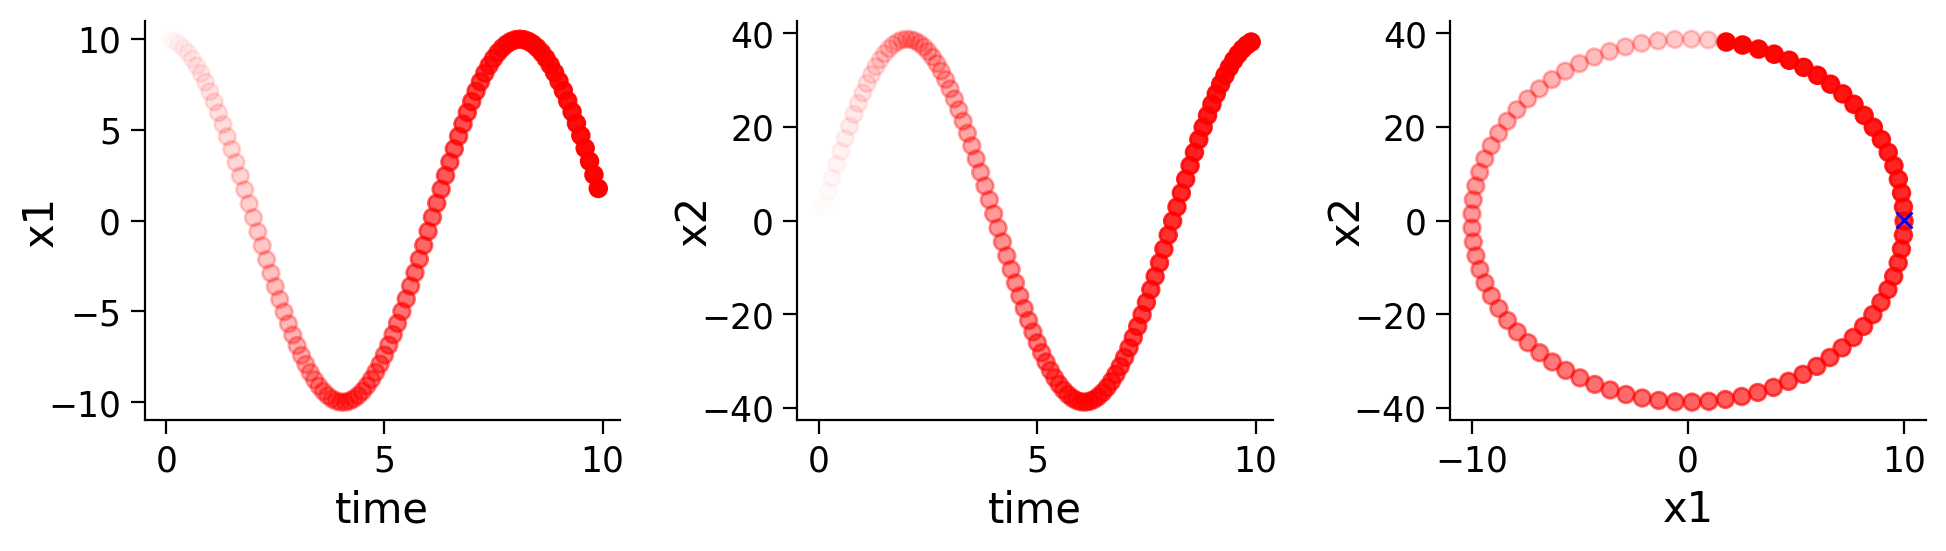

In [21]:
def system(t, x, a00, a01, a10, a11):
  '''
  Calcula la derivada del estado x en el tiempo t para una ecuación
  diferencial lineal con matriz A [[a00, a01], [a10, a11]].

  Args:
    t (float): tiempo
    x (ndarray): variable de estado
    a00, a01, a10, a11 (float): parámetros del sistema

  Devuelve:
    ndarray: derivada xdot de la variable de estado x en el tiempo t
  '''

  # calcular x1dot y x2dot
  x1dot = a00 * x[0] + a01 * x[1]
  x2dot = a10 * x[0] + a11 * x[1]

  return np.array([x1dot, x2dot])


# Establecer parámetros
T = 10 # duración total del tiempo
dt = 0.1 # paso de tiempo de nuestra simulación
# A = np.array([[2, -5],
#               [1, -2]])

A = np.array([[0, -0.2],
              [3, 0]])
# x0 = [-0.1, 0.2]
x0 = [10, 0.2]

# Simular y trazar trayectorias
plot_trajectory(system, [A[0, 0], A[0, 1], A[1, 0], A[1, 1]], x0, dt=dt, T=T)


## Demostración Interactiva 3A: Variando A

Ahora utilizaremos la función que creamos en el último ejercicio para trazar trayectorias con diferentes opciones para A. ¿Qué tipos de dinámicas cualitativamente diferentes observas?

**Consejo:** ¡Presta atención al eje x y al eje y!

In [9]:
# @markdown ¡Asegúrate de ejecutar esta celda para habilitar el widget!

# parámetros
T = 6  # Duración total del tiempo
dt = 0.1  # paso de tiempo de nuestra simulación
x0 = np.asarray([-0.1, 0.2])  # condición inicial de x en el tiempo 0

A_option_1 = [[2, -5],[1, -2]]
A_option_2 = [[3,4], [1, 2]]
A_option_3 = [[-1, -1], [0, -0.25]]
A_option_4 = [[3, -2],[2, -2]]

@widgets.interact
def plot_euler_integration(A=widgets.Dropdown(options=[A_option_1,
                                                       A_option_2,
                                                       A_option_3,
                                                       A_option_4,
                                                       None],
                                              value=A_option_1)):
  if A:
    plot_trajectory(system, [A[0][0],A[0][1],A[1][0],A[1][1]], x0, dt=dt, T=T)

interactive(children=(Dropdown(description='A', options=([[2, -5], [1, -2]], [[3, 4], [1, 2]], [[-1, -1], [0, …

## Demostración Interactiva 3B: Variando las Condiciones Iniciales

Ahora variaremos las condiciones iniciales para un $\mathbf{A}$ dado:

\begin{equation}
\dot{\mathbf{x}} = \bigg[\begin{array} & 2 & -5 \\ 1 & -2 \end{array} \bigg] \mathbf{x}
\end{equation}

¿Qué tipos de dinámicas cualitativamente diferentes observas? Consejo: ¡Presta atención al eje x y al eje y!

In [10]:
# @markdown ¡Asegúrate de ejecutar esta celda para habilitar el widget!

# parámetros
T = 6  # Duración total del tiempo
dt = 0.1  # paso de tiempo de nuestra simulación
x0 = np.asarray([-0.1, 0.2])  # condición inicial de x en el tiempo 0
A = [[2, -5],[1, -2]]

x0_option_1 = [-.1, 0.2]
x0_option_2 = [10, 10]
x0_option_3 = [-4, 3]

@widgets.interact
def plot_euler_integration(x0 = widgets.Dropdown(options=[x0_option_1,
                                                          x0_option_2,
                                                          x0_option_3,
                                                          None],
                                                 value=x0_option_1)):
  if x0:
    plot_trajectory(system, [A[0][0], A[0][1], A[1][0], A[1][1]], x0, dt=dt, T=T)

interactive(children=(Dropdown(description='x0', options=([-0.1, 0.2], [10, 10], [-4, 3], None), value=[-0.1, …

---
# Sección 4: Gráficos de Flujo

¡Es un poco tedioso trazar trayectorias una condición inicial a la vez!

Afortunadamente, para obtener una visión general de cómo una cuadrícula de condiciones iniciales afecta las trayectorias de un sistema, podemos usar un _gráfico de flujo_.

Podemos pensar en una condición inicial ${\bf x}_0=(x_{1_0},x_{2_0})$ como coordenadas para una posición en el espacio. Para una matriz 2x2 $\bf A$, un gráfico de flujo calcula en cada posición $\bf x$ una pequeña flecha que indica $\bf Ax$ y luego conecta las pequeñas flechas para formar _líneas de flujo_. Recuerda desde el principio de este tutorial que $\dot {\bf x} = \bf Ax$ es la tasa de cambio de $\bf x$. Por lo tanto, las líneas de flujo indican cómo cambia un sistema. Si te interesa una condición inicial particular ${\bf x}_0$, solo encuentra la posición correspondiente en el gráfico de flujo. La línea de flujo que pasa por ese punto en el gráfico de flujo indica ${\bf x}(t)$.

## ¡Piensa! 4: Interpretando los Valores Propios y Vectores Propios

Usando algunas funciones auxiliares, mostramos los gráficos de flujo para cada opción de A que examinaste en la demostración interactiva anterior. Incluimos los vectores propios de $\bf A$ como una línea roja (primer valor propio) y una línea azul (segundo valor propio) en los gráficos de flujo.

¿Qué tiene de especial la dirección en la que apunta el vector propio principal? ¿Y cómo se relaciona la estabilidad del sistema con los valores propios correspondientes? (Consejo: Recuerda de tu [introducción al álgebra lineal](https://www.youtube.com/watch?v=PFDu9oVAE-g&list=PLZHQObOWTQDPD3MizzM2xVFitgF8hE_ab&index=15&t=0s) que, para matrices con valores propios reales, los vectores propios indican las líneas en las que $\bf Ax$ es paralelo a $\bf x$ y los valores propios reales indican el factor por el cual $\bf Ax$ se estira o encoge en comparación con $\bf x$.)

In [11]:
# @markdown Ejecuta esta celda para ver los gráficos de flujo

A_option_1 = np.array([[2, -5], [1, -2]])
A_option_2 = np.array([[3,4], [1, 2]])
A_option_3 = np.array([[-1, -1], [0, -0.25]])
A_option_4 = np.array([[3, -2], [2, -2]])

A_options = [A_option_1, A_option_2, A_option_3, A_option_4]
plot_specific_example_stream_plots(A_options)

Output hidden; open in https://colab.research.google.com to view.